# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [2]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

#### State space checking

In [ ]:
print(env.observation_space)

Let's see an observation.

In [ ]:
obs = env.reset()
print(obs)

In the above observation : 
* the player's current sum = 21
* the dealer's face up card = 10
* does player have a _usable_ ace ? Yes ( True )

#### Action space checking

In [ ]:
print(env.action_space)

Let's pick a random action

In [ ]:
print(env.action_space.sample())

The random action picked was `HIT ( 1 )`

#### Random game playing ( Random policy )
We will execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [ ]:
EPISODES = 10
for i_episode in range(EPISODES):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.
- `prob` : _It has been added by me to have some scope to change the 80% probability to 70% or 90% to see how the game changes._

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [ ]:
def generate_episode_from_limit_stochastic(bj_env, prob=0.8):
    episode = []
    obs = bj_env.reset()
    
    while True:
        probs = [prob, 1-prob] if obs[0] > 18 else [1-prob, prob]
        action = np.random.choice([0, 1], p=probs)
        next_obs, reward, done, info = env.step(action)
        episode.append((obs, action, reward))
        obs = next_obs
        if done:
            break
    return episode

#### Playing with the policy defined above
We will execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number `EPISODES`, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [ ]:
EPISODES = 3

for i in range(EPISODES):
    print(f'Episode {i+1} :')
    print(generate_episode_from_limit_stochastic(env))

#### Playing with `prob`
Let's change the value of prob to different values and count the reward -1, 0, 1 for each `prob`
We will change the value of `prob` starting from `0.4` upto `1`. For each `prob`, We will play the games `EPISODES` times. I set the value for `EPISODES` to 100. For each episode, we will retrieve the final reward and count the number of occurance of each type of reward and save it in `rewards` list. 

In [ ]:
prob_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
rewards = [[], [], []] # index 0 : reward 0, index 1 : reward 1, index -1/2 : reward -1
for prob in prob_list:
    for i in range(3):
        rewards[i].append(0)
    
    EPISODES = 100

    for i in range(EPISODES):
        ep_description = generate_episode_from_limit_stochastic(env)
        ep_reward = int(ep_description[-1][-1])
        rewards[ep_reward][-1] = rewards[ep_reward][-1] + 1

In [ ]:
rewards_df = pd.DataFrame({'probability':prob_list,
                           '0':rewards[0],
                           '1':rewards[1],
                           '-1':rewards[-1]})

rewards_df = rewards_df.melt(id_vars=['probability'],
                var_name = 'reward',
                value_name = 'count')
sns.set_style('darkgrid')
sns.catplot(x='reward', y='count', col='probability', kind='bar', facet_kws=dict(sharey=False), data=rewards_df)

Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

For MC prediction, there are two options available : 
* Option 1 : First-Visit MC Prediction
* Option 2 : Every-Visit MC Prediction

### Option 1 : First-Visit MC Prediction

In [ ]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        ep_description = generate_episode_from_limit_stochastic(env)
        g_t = 0
        
        for t in range(len(ep_description)-1, -1, -1):
            obs_t, action_t, reward_t = ep_description[t]
            g_t = reward_t + gamma*g_t
            ep_description[t] = (obs_t, action_t, g_t)
        
        visited = set()
        for obs_t, action_t, g_t in ep_description:
            if (obs_t, action_t) not in visited:
                returns_sum[obs_t][action_t] = returns_sum[obs_t][action_t] + g_t
                N[obs_t][action_t] += 1
    
    for obs_t in returns_sum:
        Q[obs_t] = returns_sum[obs_t] / N[obs_t]
        
    return Q



Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

In [ ]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Option 2 : Every-Visit MC Prediction

In [ ]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        ep_description = generate_episode_from_limit_stochastic(env)
        g_t = 0
        
        for t in range(len(ep_description)-1, -1, -1):
            obs_t, action_t, reward_t = ep_description[t]
            g_t = reward_t + gamma*g_t
            ep_description[t] = (obs_t, action_t, g_t)
        
        for obs_t, action_t, g_t in ep_description:
            returns_sum[obs_t][action_t] = returns_sum[obs_t][action_t] + g_t
            N[obs_t][action_t] += 1
    
    for obs_t in returns_sum:
        Q[obs_t] = returns_sum[obs_t] / N[obs_t]
        
    return Q



Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

In [ ]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [3]:
def generate_action_from_policy_epsilon(bj_env, obs, policy={}, epsilon=1):
    if obs in policy:
        len_A = bj_env.action_space.n
        probs = np.ones(len_A)
        probs = probs * (epsilon / len_A)
        probs[policy[obs]] = 1 - epsilon + (epsilon / len_A)
        action = np.random.choice(np.arange(len_A), p=probs)
    else:
        action = bj_env.action_space.sample()
    return action

In [4]:
def generate_episode_from_policy(bj_env, policy={}, epsilon=1):
    obs = bj_env.reset()
    episode = []
    while True:
        action = generate_action_from_policy_epsilon(bj_env, obs, policy, epsilon)
        next_obs, reward, done, info = bj_env.step(action)
        episode.append((obs, action, reward))
        obs = next_obs
        if done:
            break
    return episode        

`epsilon` will be decreased starting from `1` to `0.1` according to a linear eqaution. So, let's say `epsilon` would be `0.1` after `n` episodes. In that case, the equation would be : 
$$ \epsilon_i = -m*(i-1) + 1$$
Where, $i = \text{current episode #}$ <br>
       $m = \frac{0.9}{n-1}$

At first, I decided to take `n` as $\frac{2}{3}$th of `num_episodes`

In [5]:
frac = 2/3.

def mc_control(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    
    # calculate m for epsilon
    n = frac*num_episodes 
    m = 0.9/(n-1)
    
    # first policy will be empty
    policy = {}
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
        # calculate epsilon of i_episode
        min_epsilon = 0.05
        epsilon_i = max(-m*(i_episode-1) + 1, 0.1) # after epsilon reaches 0.1, it will be fixed
        
        # generate episode using policy and epsilon
        episode_desc = generate_episode_from_policy(env, policy, epsilon_i)
        
        # calculate expected return G_t
        g_t = 0
        for t in range(len(episode_desc)-1, -1, -1):
            obs_t, action_t, reward_t = episode_desc[t]
            g_t = reward_t + gamma*g_t
            episode_desc[t] = (obs_t, action_t, g_t) # replacing reward_t with g_t
            
        # update Q table
        visited = set()
        
        for obs_t, action_t, g_t in episode_desc:
            if (obs_t, action_t) not in visited:
                Q[obs_t][action_t] = (1-alpha)*Q[obs_t][action_t] + alpha*g_t
                visited.add((obs_t, action_t))
                
        # update policy
        for obs_t, _, _ in episode_desc:
            policy[obs_t] = np.argmax(Q[obs_t])   
            
           
    return policy, Q

### Find bext combination of `num_episodes` and `alpha`
We will evalute a policy's perfomance by playing game with that policy and check the winning rate.
We will do grid search over these two parameters.

In [6]:
def evaluate_policy(bj_env, policy):    
    final_rewards = [0, 0, 0] # index 0 : count of reward 0, index 1 : count of reward 1, index 2/-1 : count of reward -1
    num_epsidoes = 50000


    for i_episode in range(num_epsidoes):
        episode_desc = generate_episode_from_policy(bj_env, policy, 0) # epsilon 0 means always play according to policy
        episode_reward = int(episode_desc[-1][-1])
        final_rewards[episode_reward] += 1


    winning_rate = final_rewards[1]/num_epsidoes
    return winning_rate

In [7]:
n_episodes = np.logspace(3, 6, num=8).astype('int')
n_alphas = [0.02, 0.03, 0.04] + [i*0.01 for i in range(5, 101, 5)]

best_score = -1
best_policy = {}
best_Q = None

# We will build a df and see the barplots of scores
col_episodes = []
col_alphas = []
col_scores = []

for n_episode in n_episodes:
    for n_alpha in n_alphas:
        policy, Q = mc_control(env, n_episode, n_alpha)
        score = evaluate_policy(env, policy)
        if score > best_score:
            best_score, best_episodes, best_alpha = score, n_episode, n_alpha
        col_episodes.append(n_episode)
        col_alphas.append(n_alpha)
        col_scores.append(score)
        
print('Best score : ', best_score)    
print('Best param : ', best_episodes, best_alpha)

Episode 1000000/1000000.Best score :  0.42986
Best param :  138949 0.04


### Effect of different `num_episodes` and `alpha`

We will plot `score` for different `num_episodes` and `alpha`. If we see the plotted graph, we can assume as the `num_episodes` increase winning rate increase too and for lower value of `alpha`, winning rate seems to be better 

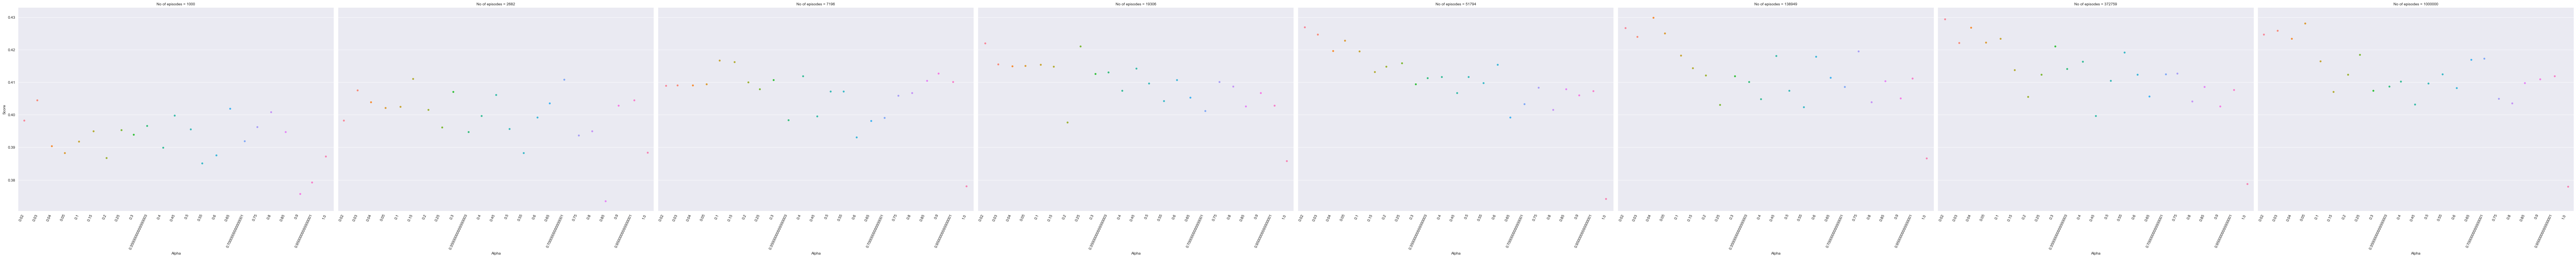

In [8]:
score_df = pd.DataFrame({'No of episodes':col_episodes, 'Alpha':col_alphas, 'Score':col_scores})

import matplotlib.pyplot as plt

sns.set_style('darkgrid')
chart = sns.catplot(x='Alpha', y='Score', col='No of episodes', height=8.27, aspect=11.7/8.27, data=score_df)
chart.set_xticklabels(rotation=65, horizontalalignment='right')

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters. In our case, we will use the best parameters we found up : `best_episodes` and `best_alpha`

In [9]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, best_episodes, best_alpha)

Episode 138000/138949.

Next, we plot the corresponding state-value function.

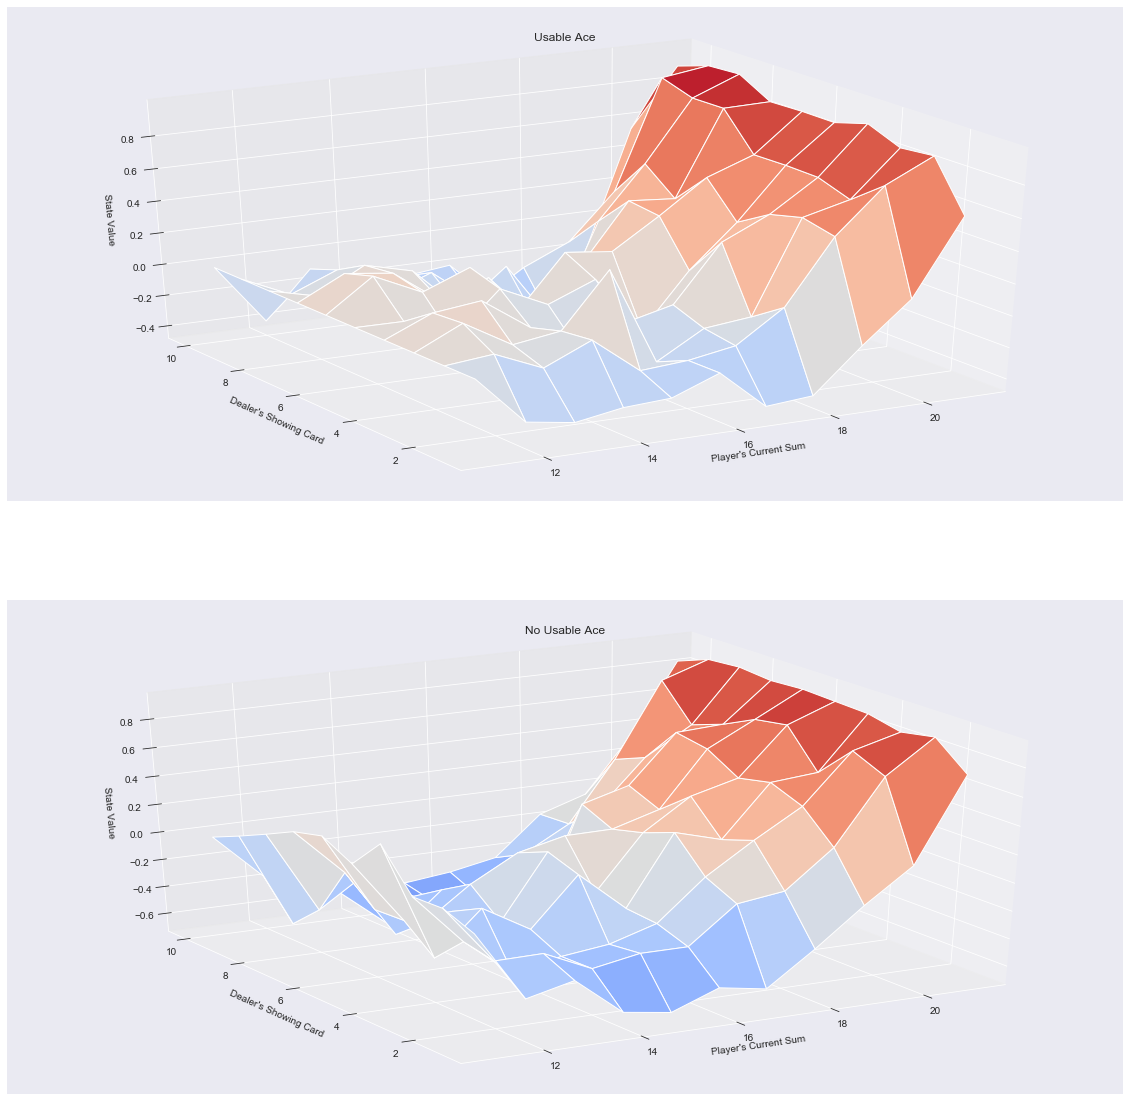

In [10]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

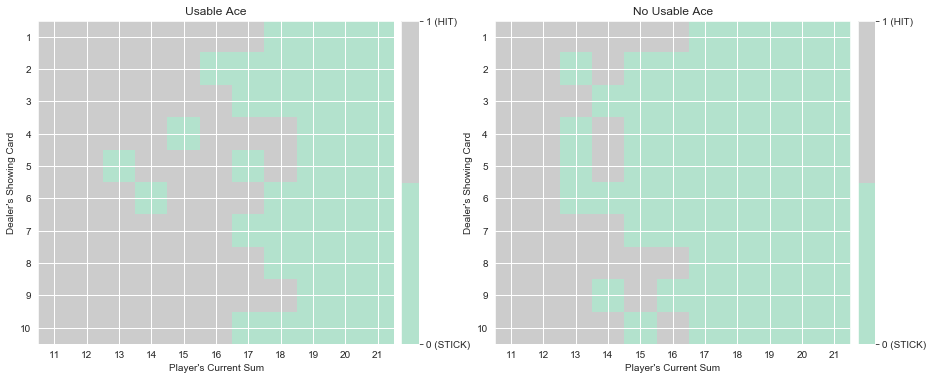

In [11]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)